<a href="https://colab.research.google.com/github/ShreyaShankar2004/shreya/blob/main/Parkinson_Handwriting_CNN_LSTM_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shreyashannkar","key":"318b095abc1ad55fa738e96235112b3e"}'}

In [2]:
# Create a directory for kaggle
!mkdir -p ~/.kaggle

# Move kaggle.json into the directory
!cp kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
# Download the dataset from Kaggle
!kaggle datasets download -d kmader/parkinsons-drawings

# Unzip the dataset
!unzip parkinsons-drawings.zip


Dataset URL: https://www.kaggle.com/datasets/kmader/parkinsons-drawings
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
Archive:  parkinsons-drawings.zip
  inflating: drawings/spiral/testing/healthy/V01HE01.png  
  inflating: drawings/spiral/testing/healthy/V02HE01.png  
  inflating: drawings/spiral/testing/healthy/V03HE1.png  
  inflating: drawings/spiral/testing/healthy/V04HE01.png  
  inflating: drawings/spiral/testing/healthy/V05HE01.png  
  inflating: drawings/spiral/testing/healthy/V06HE01.png  
  inflating: drawings/spiral/testing/healthy/V07HE01.png  
  inflating: drawings/spiral/testing/healthy/V08HE01.png  
  inflating: drawings/spiral/testing/healthy/V09HE01.png  
  inflating: drawings/spiral/testing/healthy/V10HE01.png  
  inflating: drawings/spiral/testing/healthy/V11HE01.png  
  inflating: drawings/spiral/testing/healthy/V55HE12.png  
  inflating: drawings/spiral/testing/healthy/V55HE13.png  
  inflating: drawings/spiral/testing/hea

In [11]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load all image paths and labels
def load_dataset(base_path):
    image_paths, labels = [], []
    for label in ["healthy", "parkinson"]:
        folder_path = os.path.join(base_path, label)
        for fname in os.listdir(folder_path):
            if fname.endswith(".png"):
                image_paths.append(os.path.join(folder_path, fname))
                labels.append(0 if label == "healthy" else 1)
    return image_paths, labels

train_paths, train_labels = load_dataset("drawings/spiral/training")
test_paths, test_labels = load_dataset("drawings/spiral/testing")

# Resize and convert image to sequences (row-wise)
def preprocess_images(image_paths, img_size=128):
    data = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.0
        # Treat each row as a timestep (sequence of pixels)
        data.append(img)
    return np.array(data)

X_train = preprocess_images(train_paths)
X_test = preprocess_images(test_paths)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

# Shape: (samples, timesteps, features)
X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(-1, X_test.shape[1], X_test.shape[2])


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout

# Convert each row of pixels into a CNN-processed feature
def build_model(input_shape):
    inputs = Input(shape=input_shape)

    # TimeDistributed CNN block
    x = TimeDistributed(Conv1D(32, 3, activation='relu'))(inputs)
    x = TimeDistributed(MaxPooling1D(2))(x)
    x = TimeDistributed(Flatten())(x)

    # LSTM block
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

input_shape = (X_train.shape[1], X_train.shape[2], 1)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

model = build_model(input_shape)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 128, 126, 32)   │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 128, 63, 32)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 128, 2016)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       532,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 537,089 (2.05 MB)

 Trainable params: 537,089 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=16
)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 63s 5s/step - accuracy: 0.4605 - loss: 0.6875 - val_accuracy: 0.0000e+00 - val_loss: 1.0251
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6943 - loss: 0.6540 - val_accuracy: 0.0000e+00 - val_loss: 1.1122
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6964 - loss: 0.6168 - val_accuracy: 0.0000e+00 - val_loss: 0.9645
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5553 - loss: 0.6970 - val_accuracy: 0.0000e+00 - val_loss: 0.8604
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6701 - loss: 0.6566 - val_accuracy: 0.0000e+00 - val_loss: 0.8772
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.5753 - loss: 0.6541 - val_accuracy: 0.0000e+00 - val_loss: 0.8966
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6261 - loss: 0.6950 - val_accuracy: 0.0000e+00 - val_loss: 0.9654
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5943 - loss: 0.6803 - val_accuracy: 0.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step - accuracy: 0.5000 - loss: 0.7277
Test Accuracy: 0.50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        15
           1       0.00      0.00      0.00        15

    accuracy                           0.50        30
   macro avg       0.25      0.50      0.33        30
weighted avg       0.25      0.50      0.33        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


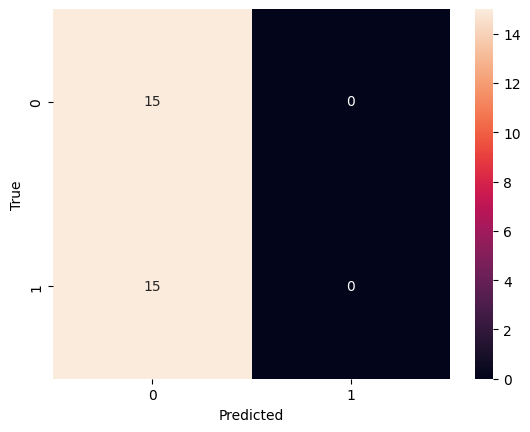

In [14]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")

# Optional: Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

def build_cnn_lstm(input_shape):
    inputs = Input(shape=input_shape)

    # CNN block (pretrained)
    base_cnn = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_cnn.trainable = False  # Freeze weights
    x = base_cnn(inputs)
    x = GlobalAveragePooling2D()(x)

    # Repeat features over time to feed into LSTM
    x = tf.expand_dims(x, axis=1)  # shape = (batch, 1, features)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

input_shape = (128, 128, 3)  # Update shape to RGB for MobileNetV2


In [16]:
def preprocess_images_rgb(image_paths, img_size=128):
    data = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.0
        data.append(img)
    return np.array(data)

X_train = preprocess_images_rgb(train_paths)
X_test = preprocess_images_rgb(test_paths)


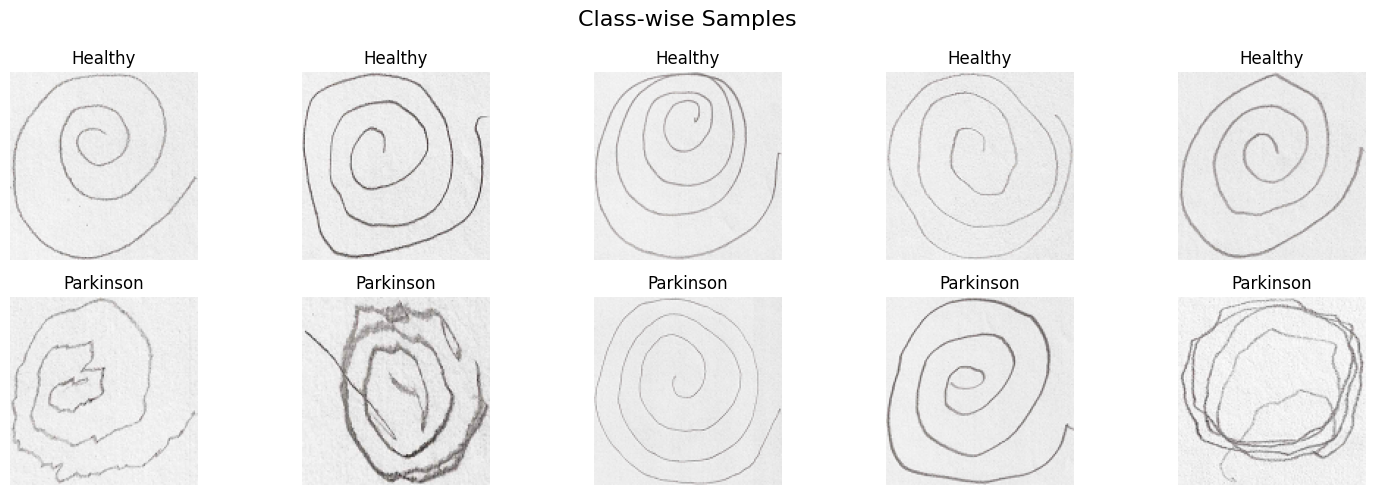

In [19]:
def show_classwise_samples(X, y, n=5):
    plt.figure(figsize=(15, 5))
    healthy = X[y == 0][:n]
    parkinson = X[y == 1][:n]

    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(healthy[i])
        plt.title("Healthy")
        plt.axis("off")

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(parkinson[i])
        plt.title("Parkinson")
        plt.axis("off")

    plt.suptitle("Class-wise Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

show_classwise_samples(X_train, y_train)



In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

# Augment only training set
train_gen = datagen.flow(X_train, y_train, batch_size=32)


In [24]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Lambda

def build_cnn_lstm(input_shape):
    inputs = Input(shape=input_shape)

    # CNN block (pretrained)
    base_cnn = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_cnn.trainable = False  # Freeze weights
    x = base_cnn(inputs)
    x = GlobalAveragePooling2D()(x)

    # Repeat features over time to feed into LSTM using a Lambda layer
    x = Lambda(lambda x: tf.expand_dims(x, axis=1))(x)  # shape = (batch, 1, features)

    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

input_shape = (128, 128, 3)  # Update shape to RGB for MobileNetV2

In [25]:
model = build_cnn_lstm((128, 128, 3))
model.fit(train_gen, validation_data=(X_test, y_test), epochs=10)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5187 - loss: 0.6915 - val_accuracy: 0.8333 - val_loss: 0.6270
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 655ms/step - accuracy: 0.6986 - loss: 0.6278 - val_accuracy: 0.7667 - val_loss: 0.5818
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 712ms/step - accuracy: 0.7747 - loss: 0.5788 - val_accuracy: 0.7667 - val_loss: 0.5274
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - accuracy: 0.7617 - loss: 0.5493 - val_accuracy: 0.8333 - val_loss: 0.4720
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step - accuracy: 0.8069 - loss: 0.5015 - val_accuracy: 0.8000 - val_loss: 0.4485
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 729ms/step - accuracy: 0.8167 - loss: 0.4564 - val_accuracy: 0.8000 - val_loss: 0.4261
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step - accuracy: 0.7780 - loss: 0.4624 - val_accuracy: 0.8000 - val_loss: 0.4034
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step - accuracy: 0.8268 - loss: 0.4219 - val_accuracy: 0.9000 - val_loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.8333 - loss: 0.3538
Test Accuracy: 0.83
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.81      0.87      0.84        15

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.83      0.83      0.83        30



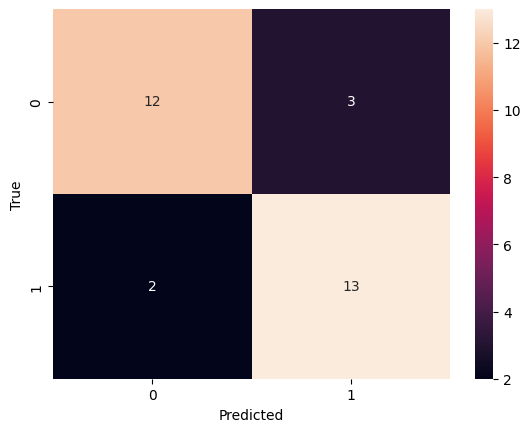

In [26]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")

# Optional: Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()